In [1]:
import wfdb #waveform database 
from wfdb import processing
import os
import glob as gb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy import signal
from sklearn.model_selection import train_test_split #to split data
import pywt #pywavelet lib
from sklearn import preprocessing
%matplotlib inline
from keras import models,layers
from keras.layers import SimpleRNN, Dense, Dropout , LSTM
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#specifies a particular record within the dataset for one patient
record_name='european-st-t-database-1.0.0/european-st-t-database-1.0.0/e0103'

In [3]:
# All Dataset & to find all files in the specified folder that have the .atr extension and located it in a list
folder_path = 'european-st-t-database-1.0.0/european-st-t-database-1.0.0'
file_paths = gb.glob(folder_path + '/*.atr')
file_paths = [os.path.splitext(path)[0].replace("\\", "/") for path in file_paths]

In [8]:
#Reading a Signal File:
record=wfdb.rdrecord(record_name)
print(record.__dict__)

{'record_name': 'e0103', 'n_sig': 2, 'fs': 250, 'counter_freq': None, 'base_counter': None, 'sig_len': 1800000, 'base_time': None, 'base_date': None, 'comments': ['Age: 62  Sex: M', 'Mixed angina', '1-vessel disease (RCA)', 'Medications: nitrates, diltiazem', 'Recorder type: ICR 7200'], 'sig_name': ['V4', 'MLIII'], 'p_signal': array([[0.455, 3.755],
       [0.46 , 3.78 ],
       [0.45 , 3.765],
       ...,
       [0.535, 3.91 ],
       [0.54 , 3.87 ],
       [0.53 , 3.865]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['e0103.dat', 'e0103.dat'], 'fmt': ['212', '212'], 'samps_per_frame': [1, 1], 'skew': [None, None], 'byte_offset': [None, None], 'adc_gain': [200.0, 200.0], 'baseline': [0, 0], 'units': ['mV', 'mV'], 'adc_res': [12, 12], 'adc_zero': [0, 0], 'init_value': [91, 751], 'checksum': [56457, 48959], 'block_size': [0, 0]}


In [15]:
#to reads the signal data from record & know signal length, The first element is a 2D numpy array with the signal data, The second element is a dictionary containing metadata about the record.
ecg_signal,_=wfdb.rdsamp(record_name)
print(len(ecg_signal))

1800000


In [16]:
ecg_signal

array([[0.455, 3.755],
       [0.46 , 3.78 ],
       [0.45 , 3.765],
       ...,
       [0.535, 3.91 ],
       [0.54 , 3.87 ],
       [0.53 , 3.865]])

In [6]:
#reads the annotation file 
annotation=wfdb.rdann(record_name,'atr')
print(annotation.__dict__)

{'record_name': 'e0103', 'extension': 'atr', 'sample': array([     15,      43,     263, ..., 1799410, 1799650, 1799902],
      dtype=int64), 'symbol': ['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N

Text(0.5, 1.0, 'Original ECG Signal')

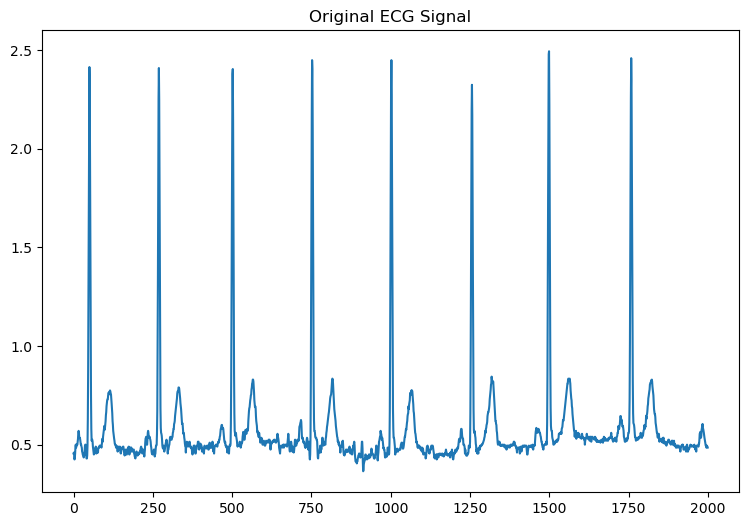

In [7]:
plt.figure(figsize=(9,6))
plt.plot(ecg_signal[0:2000,0])
plt.title('Original ECG Signal')

# Preprocessing 

In [25]:

    # Apply wavelet transform
    wavelet = 'db6'  # Choose the desired wavelet
    coeffs = pywt.wavedec(ecg_signal, wavelet) #decomposing signal 
    coeffs
    # Set a threshold for noise removal
    threshold = 0.5  # Adjust according to your signal characteristics

     # Apply thresholding to remove noise
    denoised_coeffs = [pywt.threshold(c, threshold) for c in coeffs]
    print(denoised_coeffs)
    # Reconstruct the denoised signal
    denoised_signals = pywt.waverec(denoised_coeffs, wavelet)
    print ( denoised_signals)

[array([[0.   , 3.255],
       [0.   , 3.28 ],
       [0.   , 3.265],
       ...,
       [0.035, 3.41 ],
       [0.04 , 3.37 ],
       [0.03 , 3.365]])]
[[0.    3.255]
 [0.    3.28 ]
 [0.    3.265]
 ...
 [0.035 3.41 ]
 [0.04  3.37 ]
 [0.03  3.365]]


Text(0.5, 1.0, 'ECG_denoised_signals')

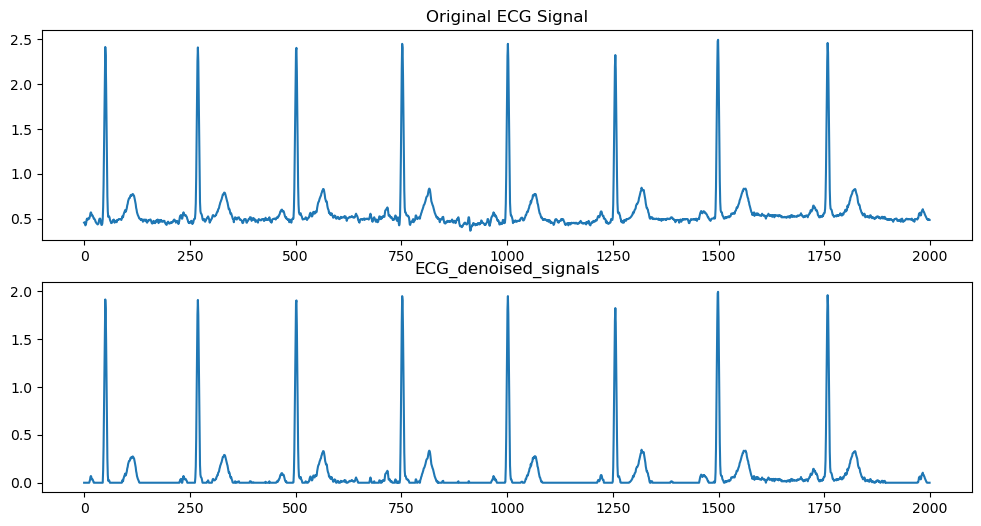

In [26]:
plt.figure(figsize=(12,6))
plt.subplot(2, 1, 1)
plt.plot(ecg_signal[:2000,0])
plt.title('Original ECG Signal')
plt.subplot(2, 1, 2)
plt.plot(denoised_signals[0:2000,0])
plt.title('ECG_denoised_signals')

In [29]:
#Z-Score Normalization
normalize_signal=(ecg_signal-np.mean(ecg_signal))/np.std(ecg_signal)

Text(0.5, 1.0, 'ECG_Normalized_signals')

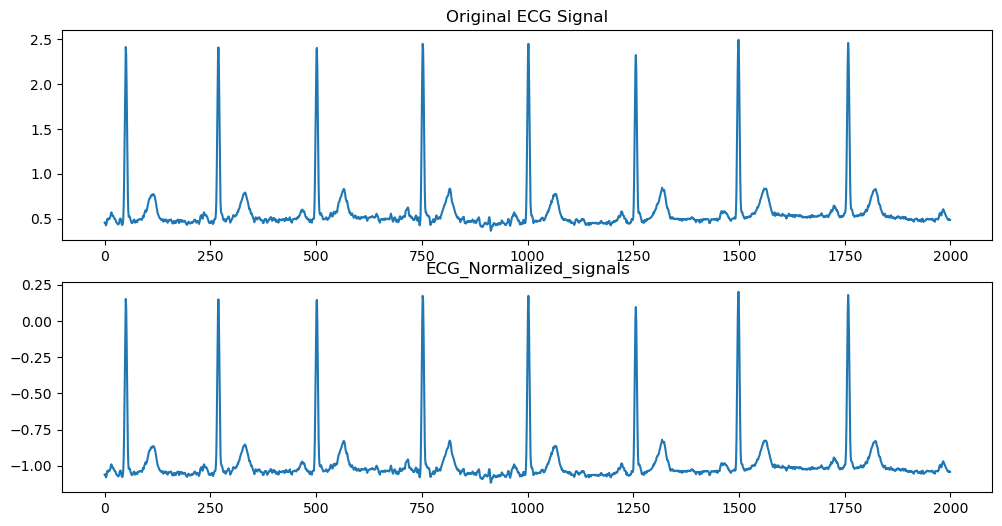

In [11]:
plt.figure(figsize=(12,6))
plt.subplot(2, 1, 1)
plt.plot(ecg_signal[:2000,0])
plt.title('Original ECG Signal')
plt.subplot(2, 1, 2)
plt.plot(normalize_signal[:2000,0])
plt.title('ECG_Normalized_signals')

In [41]:
# Read the ECG signal and annotation file using the wfdb library
annotation = wfdb.rdann(record_name, 'atr', sampfrom=0, sampto=record.sig_len)

# Get the indices of the QRS complexes (peaks)
qrs_inds = annotation.sample

# Define the duration (in samples) for each beat segment
beat_duration = int(0.2 * record.fs)  # Assuming a 200 ms duration for each beat

# Split the ECG signal into individual beats
beats = []
for qrs_ind in qrs_inds:
#Calculate the start and end points of each beat segment, ensuring they stay within the bounds of the signal.
    start = max(0, qrs_ind - beat_duration // 2)  # Start of the beat segment
    end = min(qrs_ind + beat_duration // 2, record.sig_len)  # End of the beat segment
    beat = record.p_signal[start:end,0]  # Extract the beat segment
    beat=beat.tolist()
    if len(beat)<50:
        a=min(beat)
        for i in range(50-len(beat)):
            beat.append(a)
    beats.append(beat)
    beat=[]
print(beats)


[[0.455, 0.46, 0.45, 0.425, 0.435, 0.455, 0.49, 0.5, 0.485, 0.5, 0.495, 0.5, 0.5, 0.515, 0.53, 0.56, 0.57, 0.56, 0.535, 0.535, 0.535, 0.525, 0.51, 0.5, 0.5, 0.49, 0.485, 0.465, 0.46, 0.45, 0.445, 0.44, 0.435, 0.44, 0.445, 0.475, 0.495, 0.5, 0.5, 0.48, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425], [0.535, 0.535, 0.535, 0.525, 0.51, 0.5, 0.5, 0.49, 0.485, 0.465, 0.46, 0.45, 0.445, 0.44, 0.435, 0.44, 0.445, 0.475, 0.495, 0.5, 0.5, 0.48, 0.45, 0.43, 0.43, 0.445, 0.495, 0.63, 0.88, 1.29, 1.77, 2.19, 2.415, 2.32, 1.985, 1.535, 1.085, 0.75, 0.58, 0.52, 0.525, 0.525, 0.515, 0.49, 0.475, 0.465, 0.45, 0.455, 0.455, 0.465], [0.535, 0.54, 0.54, 0.53, 0.525, 0.515, 0.495, 0.485, 0.465, 0.455, 0.46, 0.45, 0.455, 0.455, 0.465, 0.475, 0.475, 0.45, 0.44, 0.45, 0.455, 0.48, 0.495, 0.495, 0.5, 0.555, 0.67, 0.965, 1.36, 1.85, 2.26, 2.41, 2.25, 1.835, 1.37, 0.935, 0.685, 0.585, 0.56, 0.555, 0.545, 0.525, 0.495, 0.485, 0.48, 0.485, 0.495, 0.485, 0.465, 0.475], [0.585, 0.58, 0.56, 0.

TypeError: list indices must be integers or slices, not tuple

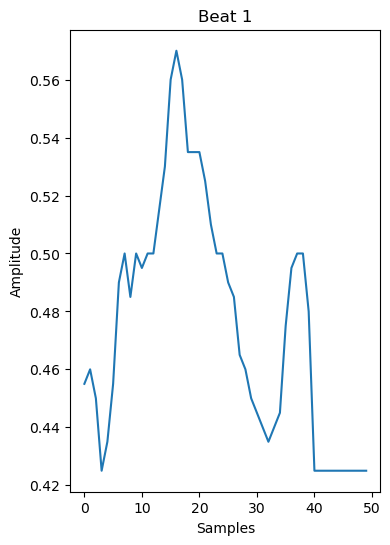

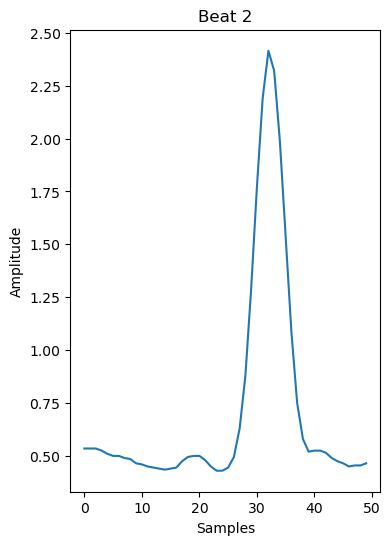

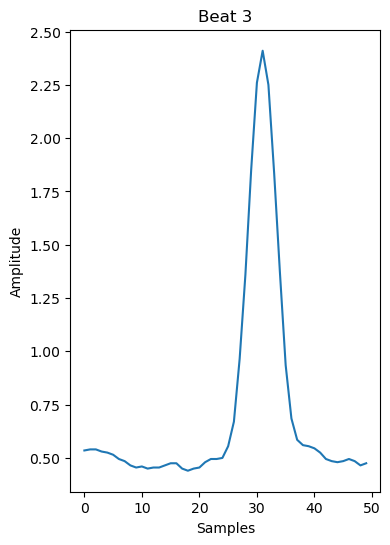

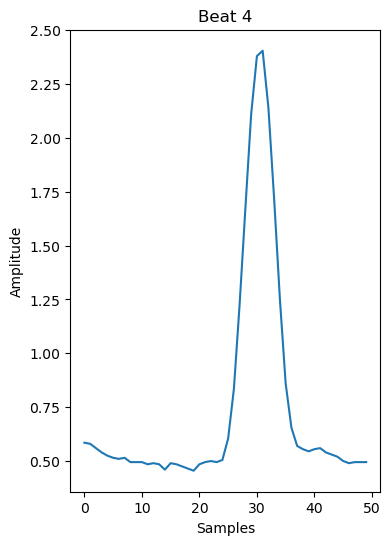

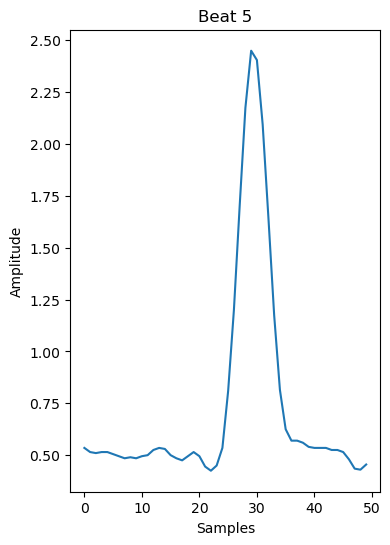

In [66]:
# Plot the first few beats
for i in range(min(5, len(beats))):
    plt.figure(figsize=(4,6))
    plt.plot(beats[i])
    plt.title(f"Beat {i+1}")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.show()


In [45]:
beats=np.array(beats)
beats


array([[0.455, 0.46 , 0.45 , ..., 0.425, 0.425, 0.425],
       [0.535, 0.535, 0.535, ..., 0.455, 0.455, 0.465],
       [0.535, 0.54 , 0.54 , ..., 0.485, 0.465, 0.475],
       ...,
       [0.54 , 0.525, 0.51 , ..., 0.5  , 0.49 , 0.49 ],
       [0.53 , 0.54 , 0.535, ..., 0.485, 0.485, 0.495],
       [0.555, 0.54 , 0.535, ..., 0.5  , 0.5  , 0.515]])

In [47]:
annotation_symbols=annotation.symbol

In [67]:
#convert each annotation to a number to be easier for the model
my_set_labels=set(annotation_symbols)
my_set_numbers=set(range(len(my_set_labels)))
my_dic = dict(zip(my_set_labels,my_set_numbers))
#each symbol in annotation_symbols is replaced by its corresponding number from my_dic
converted_list = np.array([my_dic.get(item, item) for item in annotation_symbols])
print(my_set_labels,my_set_numbers,my_dic,converted_list)

{'V', '+', 'N', '~', 'F', 's'} {0, 1, 2, 3, 4, 5} {'V': 0, '+': 1, 'N': 2, '~': 3, 'F': 4, 's': 5} [1 2 2 ... 2 2 2]


In [71]:
X_train,X_test,Y_train , Y_test = train_test_split(beats , converted_list , test_size=0.3 ,random_state=42 )
X_test, X_valid,Y_test ,Y_valid = train_test_split(X_test,Y_test , test_size=0.5 ,random_state=42 )


In [72]:
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Validation set size: {len(X_valid)}")

Training set size: 5135
Test set size: 1100
Validation set size: 1101


In [73]:
X_train.shape

(5135, 50)

# MODELS

In [74]:
model = models.Sequential([
    layers.Flatten(input_shape=(X_train.shape[1],)),  # Flatten the 2D input array
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='relu')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, Y_train, epochs=10, batch_size=1)

Epoch 1/10
5135/5135 ━━━━━━━━━━━━━━━━━━━━ 4s 633us/step - accuracy: 0.0063 - loss: -15.6632
Epoch 2/10
5135/5135 ━━━━━━━━━━━━━━━━━━━━ 3s 667us/step - accuracy: 0.0114 - loss: -15.7669
Epoch 3/10
5135/5135 ━━━━━━━━━━━━━━━━━━━━ 3s 635us/step - accuracy: 0.0096 - loss: -15.8253
Epoch 4/10
5135/5135 ━━━━━━━━━━━━━━━━━━━━ 3s 656us/step - accuracy: 0.0118 - loss: -15.8573
Epoch 5/10
5135/5135 ━━━━━━━━━━━━━━━━━━━━ 3s 640us/step - accuracy: 0.0098 - loss: -15.7527
Epoch 6/10
5135/5135 ━━━━━━━━━━━━━━━━━━━━ 3s 662us/step - accuracy: 0.0076 - loss: -15.3495
Epoch 7/10
5135/5135 ━━━━━━━━━━━━━━━━━━━━ 3s 631us/step - accuracy: 0.0104 - loss: -15.2829
Epoch 8/10
5135/5135 ━━━━━━━━━━━━━━━━━━━━ 3s 623us/step - accuracy: 0.0073 - loss: -15.4139
Epoch 9/10
5135/5135 ━━━━━━━━━━━━━━━━━━━━ 3s 627us/step - accuracy: 0.0061 - loss: -15.2660
Epoch 10/10
5135/5135 ━━━━━━━━━━━━━━━━━━━━ 3s 654us/step - accuracy: 0.0093 - loss: -15.4153


In [75]:
predictions = model.predict(X_valid)

print("Predictions:", predictions)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Predictions: [[4.148181 ]
 [3.9660945]
 [3.092505 ]
 ...
 [5.4511065]
 [5.713959 ]
 [3.708103 ]]


In [76]:
 model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           3,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,669 (69.02 KB)

 Trainable params: 5,889 (23.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,780 (46.02 KB)

In [100]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, Y_test)

# Print the accuracy
print("Test Accuracy:", accuracy)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0140 - loss: -15.3529 
Test Accuracy: 0.010909090749919415


In [90]:
# Predict labels for the test set
y_pred = model.predict(X_test)
print(y_pred)
# Convert predicted probabilities to binary predictions (0 or 1)
y_pred_binary = (y_pred > 4.1).astype(int)
print(y_pred_binary)

# Calculate true positives (TP) and false negatives (FN)
TP = sum((y_pred_binary == 1) & (Y_test == 1))
FN = sum((y_pred_binary == 0) & (Y_test == 1))

# Calculate sensitivity (true positive rate)
sensitivity = TP / (TP + FN)

print("Sensitivity:", sensitivity)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
[[4.708929 ]
 [5.471678 ]
 [4.416699 ]
 ...
 [4.462024 ]
 [3.6594844]
 [3.449749 ]]
[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
Sensitivity: [nan nan nan ... nan nan nan]


C:\Users\Toqa\AppData\Local\Temp\ipykernel_17936\958397247.py:13: RuntimeWarning: invalid value encountered in divide
  sensitivity = TP / (TP + FN)


In [70]:
# Predict labels for the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to binary predictions (0 or 1)
y_pred_binary = (y_pred > 4.1).astype(int)

# Calculate true negatives (TN) and false positives (FP)
TN = sum((y_pred_binary == 0) & (Y_test == 0))
FP = sum((y_pred_binary == 1) & (Y_test == 0))

# Calculate specificity (true negative rate)
specificity = TN / (TN + FP)

print("Specificity:", specificity)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
Specificity: [nan nan nan ... nan nan nan]


C:\Users\Toqa\AppData\Local\Temp\ipykernel_17936\28263745.py:12: RuntimeWarning: invalid value encountered in divide
  specificity = TN / (TN + FP)


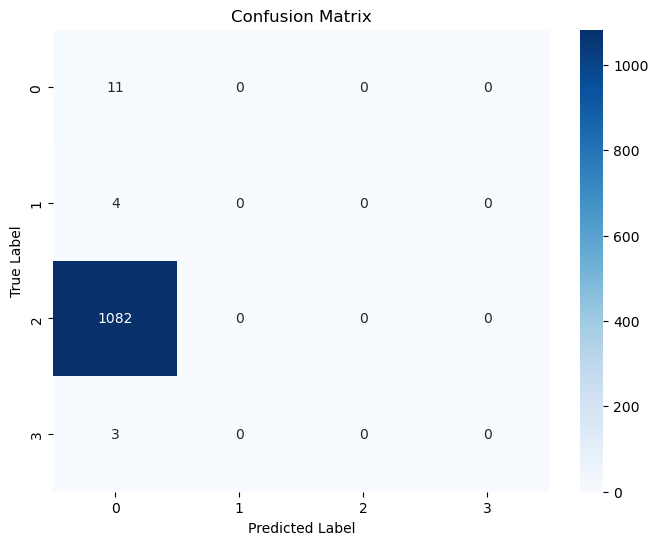

In [98]:
# Assuming y_pred_classes and Y_test are the predicted and true labels, respectively

# Convert predicted probabilities to class predictions
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(Y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
